# Channel Attribution

Attributions are useful when examining how different parts of a model contribute the final output. Though attribution alone lack the context as to why that attribution value exists for the target, and thus we visualize the corresponding activations.

For this section of the guide, we will be using Captum's attr submodule to collect channel attributions and then the Optim module will be used to provide context for the calculated attributions.

Below we define two helper functions to help of us visualize channel attributions and their corresponding activation visualizations.

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from typing import List

from captum import attr
import captum.optim as opt
from captum.optim.models import googlenet

import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First we'll load our test image to use for calculating channel attributions:

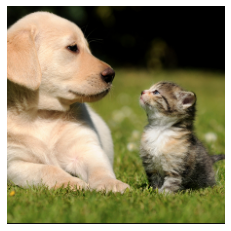

In [ ]:
input_image = opt.ImageTensor.open(
    "https://user-images.githubusercontent.com/10626398/145851549-69251f3b-3b52-4d55-9db4-878c52685377.png"
).to(device)
input_image.show()

Next we nned to load a version of our Inceptionv1 model for calculating attributions, and another version for creating visualizations. The attribution version of the model does not contain the standard `RedirectedRelu` layers instead of `ReLU` layers as the redirected ReLU interferes with attribution calculations.

In [ ]:
model = googlenet(pretrained=True).to(device).eval()
attr_model = googlenet(pretrained=True, replace_relus_with_redirectedrelu=False).to(device).eval()

Now that we have the two versions of our models loaded, we can define our helper functions for visualization and attribution calculations.

In [ ]:
def vis_channel_list(
    model: torch.nn.Module, target: torch.nn.Module, channel_list: List[int]
) -> torch.Tensor:
    loss_fn_list = [
        opt.loss.ChannelActivation(target, c, batch_index=i)
        for i, c in enumerate(channel_list)
    ]
    loss_fn = sum(loss_fn_list)
    image = opt.images.NaturalImage((80, 80), batch=len(loss_fn_list)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(4),
        opt.transforms.RandomSpatialJitter(8),
        opt.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        opt.transforms.RandomSpatialJitter(2),
        opt.transforms.CenterCrop((80, 80)),
    )
    obj = opt.InputOptimization(model, loss_fn, image, transform=transforms)
    history = obj.optimize(opt.optimization.n_steps(128, False))
    return image().detach()


def vis_channel_attr(
    attr_tensor: torch.Tensor,
    model: torch.nn.Module,
    target: torch.nn.Module,
    n_show: int = 3,
) -> None:

    def plot_distribution(vals, color: str = "r") -> None:
        vals = [abs(float(v)) for v in vals]
        fig, ax = plt.subplots()
        ax.bar(list(range(0, len(vals))), vals, width=1, color=color)
        plt.box(False)
        plt.axis("off")
        plt.show()

    ns_pos = torch.argsort(-attr_tensor)
    ns_pos_show = ns_pos[:n_show].tolist()
    ns_pos_attr = [float(attr_tensor[i]) for i in ns_pos_show]

    print("Distribution of positive attributions across channels:")
    plot_distribution([t for t in torch.sort(attr_tensor)[0] if t < 0], "r")
    print("Top channels with postive attributions:", ns_pos_show)
    print(ns_pos_attr)

    imgs = vis_channel_list(model, target, ns_pos_show)
    pos_imgs = torchvision.utils.make_grid(imgs, nrow=imgs.shape[0])
    opt.show(pos_imgs)
    
    print("\n" + "-" * 50 + "\n")

    # We reverse the list to match the graph
    ns_neg = torch.argsort(attr_tensor)
    ns_neg_show = ns_neg[:n_show].tolist()
    ns_neg_show.reverse()
    ns_neg_attr = [float(attr_tensor[i]) for i in ns_neg_show]

    print("Distribution of negative attributions across channels:\n")
    plot_distribution([t for t in torch.sort(attr_tensor)[0] if t > 0], "b")
    print("Top channels with negative attributions:", ns_neg_show)
    print(ns_neg_attr)

    imgs = vis_channel_list(model, target, ns_neg_show).flip([0])
    neg_imgs = torchvision.utils.make_grid(imgs, nrow=imgs.shape[0])
    opt.show(neg_imgs)

To calculate attributions for the target layer and classes, we will use the attr submodule's [`LayerGradientXActivation`](https://captum.ai/api/layer.html#layer-gradient-x-activation) class.

In [ ]:
# Calculate attributions for the target output classes
get_attr = attr.LayerGradientXActivation(attr_model, attr_model.mixed4d_relu)


As you may have noticed, our test image contains both a dog and a kitten. We can filter out the kitten related attributions by subtracting them from the dog attributions.

In [ ]:
# Labrador retriever: 176, tiger cat: 55
attr_tensor_176_55 = get_attr.attribute(input_image, 176) - get_attr.attribute(input_image, 55)

Now that we have our attributions, we can reduce them down to their channels for sorting and rendering.

In [ ]:
# Reduce output down to channels
attr_tensor = attr_tensor_176_55[0].sum(1).sum(1)

Now that everything is ready, we can now generate our channel attribution visualizations, attributions, and graphs!

Below we can see the top 3 most extreme attributions in both directions, and their correspending channel visualizations.

Distribution of positive attributions across channels:


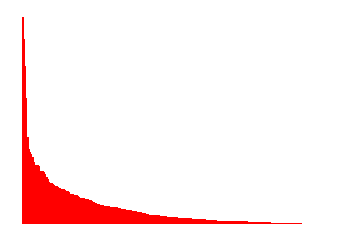

Top channels with postive attributions: [426, 436, 43]
[1.6280022859573364, 1.5053555965423584, 1.1942988634109497]


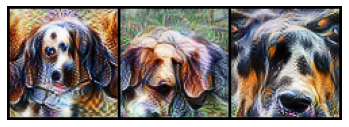


--------------------------------------------------

Distribution of negative attributions across channels:



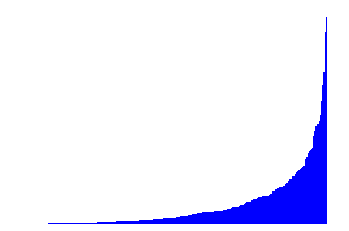

Top channels with negative attributions: [493, 517, 221]
[-1.3174381256103516, -1.5371028184890747, -1.7237980365753174]


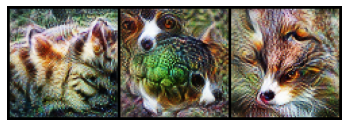

In [ ]:
# Visualize the results
vis_channel_attr(attr_tensor, model, model.mixed4d_relu, n_show=3)